# U-Bahn Analysis - Public Transportation Accessibility Category

## Comprehensive EDA for #well-connected and #remote labels

**Tags:**  #public-transport #transportation #accessibility #metro #subway #connectivity

## 2.1 Deep Dive into ubahn

**Chosen Category:** Public Transportation Accessibility (#well-connected, #remote)

**Labels to analyze:**
- #well-connected: High density of U-Bahn stations and good connectivity
- #remote: Low density of U-Bahn stations and poor connectivity

**Additional relevant tags:** #metro-access #transport-infrastructure #urban-mobility #transit-oriented #accessibility-score

## 2.2 Perform Comprehensive EDA on U-Bahn Accessibility Parameters

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully")

All libraries imported successfully


In [2]:
!pip install -q geopandas shapely pyproj

In [3]:
!pip install -q "folium>=0.12" mapclassify matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 10.3 MB/s eta 0:00:00


In [4]:
# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Load
path = '/content/drive/My Drive/webeet/tables_from_db_csv'
path_1 = path + "/ubahns.csv"
path_2 = path + "/bus_tram_stops.csv"
df_ubahn = pd.read_csv(path_1)
df_bus_tram = pd.read_csv(path_2)
# 3) First Check
print(df_ubahn.shape)
print(df_bus_tram.shape)



Mounted at /content/drive
(191, 8)
(2899, 8)


In [5]:
print("------Ubahns: -----")
print(df_ubahn.head())
print("------Bus_Tram:----")
print(df_bus_tram.head())
print("------U_bahn Info:----")
print(df_ubahn.info())
print("------Bus_Tram Info:----")
print(df_bus_tram.info())

print(df_ubahn.columns.tolist())
print(df_bus_tram.columns.tolist())

------Ubahns: -----
               station line   latitude  longitude  postcode    neighborhood  \
0        Adenauerplatz   U7  52.499722  13.307222   10707.0  Charlottenburg   
1  Afrikanische Straße   U6  52.560028  13.334633   13349.0         Wedding   
2       Alexanderplatz   U5  52.521389  13.411944   10178.0           Mitte   
3       Alexanderplatz   U2  52.521389  13.411944   10178.0           Mitte   
4       Alexanderplatz   U8  52.521389  13.411944   10178.0           Mitte   

                     district  district_id  
0  Charlottenburg-Wilmersdorf     11004004  
1                       Mitte     11001001  
2                       Mitte     11001001  
3                       Mitte     11001001  
4                       Mitte     11001001  
------Bus_Tram:----
     stop_id  district_id                                       name  \
0  900086106     11012012  Auguste-Viktoria-A./Humboldtstr. (Berlin)   
1  900170515     11010010                    Adersleber Weg (Berlin)   

In [6]:
import re, pandas as pd
from collections import Counter

# 1) Canonical key (for joining)
def canon_nh(x: str) -> str:
    if pd.isna(x):
        return x
    s = str(x).strip().lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    s = re.sub(r"[^a-z0-9]+", "", s)  # drop hyphens/spaces/etc.
    return s

# 2) Add canonical keys (non-destructive)
ub = df_ubahn.copy()
bt = df_bus_tram.copy()
ub["neighborhood_canon"] = ub["neighborhood"].map(canon_nh)
bt["neighborhood_canon"] = bt["neighborhood"].map(canon_nh)

# 3) Build a 'pretty' display mapping per canonical key
def has_diacritic(s: str) -> bool:
    return any(ch in s for ch in "äöüÄÖÜß")

def pick_pretty(names):
    """
    Choose a friendly display variant:
      (a) most frequent spelling, then
      (b) prefer one with diacritics, then
      (c) prefer one with hyphen(s), then
      (d) shortest
    """
    counts = Counter(names)
    def key_fn(s):
        return (counts[s], 1 if has_diacritic(s) else 0, 1 if "-" in s else 0, -len(s))
    return max(counts.keys(), key=key_fn)

cand = (pd.concat([ub[["neighborhood_canon","neighborhood"]],
                   bt[["neighborhood_canon","neighborhood"]]], ignore_index=True)
          .dropna(subset=["neighborhood_canon","neighborhood"]))

mapping_df = (cand.groupby("neighborhood_canon")["neighborhood"]
                   .apply(lambda s: pick_pretty(list(s)))
                   .reset_index()
                   .rename(columns={"neighborhood":"neighborhood_display"}))

# Optional manual overrides (use this if you want to force a specific look)
MANUAL_OVERRIDES = {
    # "althohenschoenhausen": "Alt-Hohenschönhausen",
    # "franzoesischbuchholz": "Französisch Buchholz",
    # "koepenick": "Köpenick",
    # "gruenau": "Grünau",
    # "luebars": "Lübars",
}
if MANUAL_OVERRIDES:
    mapping_df["neighborhood_display"] = mapping_df.apply(
        lambda r: MANUAL_OVERRIDES.get(r["neighborhood_canon"], r["neighborhood_display"]), axis=1
    )

# Persist mapping for reuse later
mapping_path = "neighborhood_display_mapping.csv"
mapping_df.to_csv(mapping_path, index=False)

# 4) Aggregate counts and merge by (district_id, neighborhood_canon)
ub_counts = (ub.groupby(["district_id","district","neighborhood_canon"], dropna=False)
               .agg(ubahn_stations=("station","nunique"))
               .reset_index())
bt_counts = (bt.groupby(["district_id","district","neighborhood_canon"], dropna=False)
               .agg(bus_tram_stops=("stop_id","nunique"))
               .reset_index())

merged = ub_counts.merge(
    bt_counts, on=["district_id","neighborhood_canon"], how="outer", suffixes=("_ub","_bt")
)
merged["district"] = merged["district_ub"].fillna(merged["district_bt"])
merged = merged.drop(columns=["district_ub","district_bt"])

# Attach pretty display names
merged = merged.merge(mapping_df, on="neighborhood_canon", how="left")

# Fill counts, compute total
merged["ubahn_stations"] = merged["ubahn_stations"].fillna(0).astype(int)
merged["bus_tram_stops"] = merged["bus_tram_stops"].fillna(0).astype(int)
merged["total_stops"] = merged["ubahn_stations"] + merged["bus_tram_stops"]

# Nice order
merged = merged.sort_values(["district","neighborhood_display"]).reset_index(drop=True)

# Save merged counts
out_counts_path = "neighborhood_merged_counts.csv"
merged.to_csv(out_counts_path, index=False)

print("Saved:")
print(" -", mapping_path)
print(" -", out_counts_path)

# Quick sanity checks
print("\nOnly-U-Bahn neighborhoods (by canonical, any district):")
only_ub = sorted(set(ub["neighborhood_canon"]) - set(bt["neighborhood_canon"]))
display(mapping_df[mapping_df["neighborhood_canon"].isin(only_ub)])

print("\nOnly-Bus/Tram neighborhoods (by canonical, any district):")
only_bt = sorted(set(bt["neighborhood_canon"]) - set(ub["neighborhood_canon"]))
display(mapping_df[mapping_df["neighborhood_canon"].isin(only_bt)].head(20))

# Peek the merged result
merged.head(20)


Saved:
 - neighborhood_display_mapping.csv
 - neighborhood_merged_counts.csv

Only-U-Bahn neighborhoods (by canonical, any district):


,neighborhood_canon,neighborhood_display
33,haselhorst,Haselhorst
70,tegel,Tegel
77,wittenau,Wittenau



Only-Bus/Tram neighborhoods (by canonical, any district):


,neighborhood_canon,neighborhood_display
0,adlershof,Adlershof
1,altglienicke,Altglienicke
2,althohenschoenhausen,Alt-Hohenschönhausen
3,alttreptow,Alt-Treptow
4,baumschulenweg,Baumschulenweg
6,blankenburg,Blankenburg
7,blankenfelde,Blankenfelde
8,bohnsdorf,Bohnsdorf
9,borsigwalde,Borsigwalde
11,buch,Buch


,district_id,neighborhood_canon,ubahn_stations,bus_tram_stops,district,neighborhood_display,total_stops
0,11004004,charlottenburg,8,81,Charlottenburg-Wilmersdorf,Charlottenburg,89
1,11004004,charlottenburgnord,3,16,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,19
2,11004004,grunewald,0,64,Charlottenburg-Wilmersdorf,Grunewald,64
3,11004004,halensee,0,11,Charlottenburg-Wilmersdorf,Halensee,11
4,11004004,schmargendorf,0,15,Charlottenburg-Wilmersdorf,Schmargendorf,15
5,11004004,westend,3,51,Charlottenburg-Wilmersdorf,Westend,54
6,11004004,wilmersdorf,9,26,Charlottenburg-Wilmersdorf,Wilmersdorf,35
7,11002002,friedrichshain,5,28,Friedrichshain-Kreuzberg,Friedrichshain,33
8,11002002,kreuzberg,10,92,Friedrichshain-Kreuzberg,Kreuzberg,102
9,11011011,althohenschoenhausen,0,81,Lichtenberg,Alt-Hohenschönhausen,81


In [7]:
path_3 = path + "/neighbornhoods.csv"
df_nei = pd.read_csv(path_3)
print(df_nei.head())
print(df_nei.columns.to_list())

   district_id district  neighborhood_id  neighborhood  \
0     11001001    Mitte              101         Mitte   
1     11001001    Mitte              102        Moabit   
2     11001001    Mitte              103  Hansaviertel   
3     11001001    Mitte              104    Tiergarten   
4     11001001    Mitte              105       Wedding   

                                            geometry  
0  0106000020E61000000100000001030000000100000006...  
1  0106000020E61000000100000001030000000100000002...  
2  0106000020E61000000100000001030000000100000006...  
3  0106000020E61000000100000001030000000100000055...  
4  0106000020E6100000010000000103000000010000004E...  
['district_id', 'district', 'neighborhood_id', 'neighborhood', 'geometry']


In [8]:
# !pip install -q geopandas shapely pyproj  # then Runtime -> Restart

import geopandas as gpd
from shapely import wkb

gdf_nei = df_nei.copy()
# convert EWKB hex -> shapely geometry
gdf_nei["geometry"] = gdf_nei["geometry"].apply(lambda s: wkb.loads(s, hex=True))

# pass the COLUMN NAME (str) + string CRS — this usually satisfies Pylance
gdf_nei = gpd.GeoDataFrame(gdf_nei, geometry="geometry", crs="EPSG:4326")


In [9]:
type(gdf_nei.geometry.iloc[0])   # expect shapely Polygon/MultiPolygon
gdf_nei.crs                      # EPSG:4326
print(gdf_nei.head(2))

# exact areas (km²) using a metric CRS for Berlin
gdf_utm = gdf_nei.to_crs(25833)  # ETRS89 / UTM 33N
gdf_nei["area_km2"] = gdf_utm.area / 1e6


   district_id district  neighborhood_id neighborhood  \
0     11001001    Mitte              101        Mitte   
1     11001001    Mitte              102       Moabit   

                                            geometry  
0  MULTIPOLYGON (((13.41649 52.52696, 13.41635 52...  
1  MULTIPOLYGON (((13.33884 52.51974, 13.33884 52...  


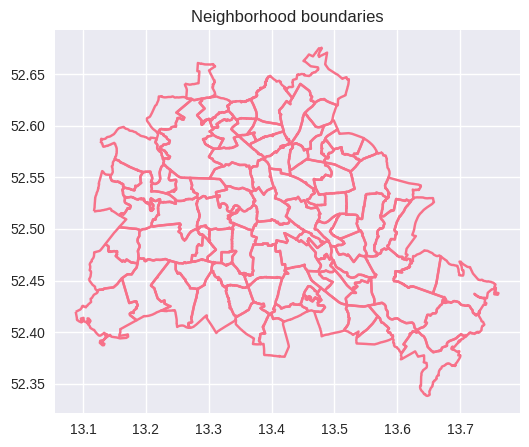

In [10]:
# exact neighborhood area (km²) – use a metric CRS for accuracy in Berlin
# EPSG:25833 = ETRS89 / UTM zone 33N (great for Berlin areas)
gdf_nei_utm = gdf_nei.to_crs(25833)
gdf_nei["area_km2"] = gdf_nei_utm.area / 1e6

# centroids / bounds
gdf_nei["centroid"] = gdf_nei.geometry.centroid
gdf_nei[['minx', 'miny', 'maxx', 'maxy']] = gdf_nei.geometry.bounds

# quick plot
ax = gdf_nei.boundary.plot(figsize=(6,6))
_ = ax.set_title("Neighborhood boundaries")

In [11]:
import geopandas as gpd
import numpy as np
import pandas as pd

# Points -> GeoDataFrames (CRS matches polygons: 4326)
gub = gpd.GeoDataFrame(
    df_ubahn.copy(),
    geometry=gpd.points_from_xy(df_ubahn["longitude"], df_ubahn["latitude"]),
    crs=4326
)
gbt = gpd.GeoDataFrame(
    df_bus_tram.copy(),
    geometry=gpd.points_from_xy(df_bus_tram["longitude"], df_bus_tram["latitude"]),
    crs=4326
)

# Keep polygon attributes needed
poly_keys = ["district_id","district","neighborhood_id","neighborhood","geometry"]
polys = gdf_nei[poly_keys].copy()

# Spatial join with explicit suffixes (as you had)
gub_j = gpd.sjoin(gub, polys, how="left", predicate="within", lsuffix="_ub", rsuffix="_poly")
gbt_j = gpd.sjoin(gbt, polys, how="left", predicate="within", lsuffix="_bt", rsuffix="_poly")

# Use the actual column names produced by the join
right_did = "district_id__poly"
nid_col   = "neighborhood_id"

# Drop points that didn't land in any polygon (NaNs on the right)
gub_j2 = gub_j.dropna(subset=[right_did, nid_col]).copy()
gbt_j2 = gbt_j.dropna(subset=[right_did, nid_col]).copy()

# Cast to integer (nullable safe) so groupby keys are clean
gub_j2[right_did] = gub_j2[right_did].astype("Int64")
gbt_j2[right_did] = gbt_j2[right_did].astype("Int64")
gub_j2[nid_col]   = gub_j2[nid_col].astype("Int64")
gbt_j2[nid_col]   = gbt_j2[nid_col].astype("Int64")

# Counts per neighborhood (unique station / stop_id)
ub_counts = (gub_j2.groupby([right_did, nid_col])
                 .size()
                 .reset_index(name="ubahn_stations")
                 .rename(columns={right_did: "district_id"}))

bt_counts = (gbt_j2.groupby([right_did, nid_col])
                 .size()
                 .reset_index(name="bus_tram_stops")
                 .rename(columns={right_did: "district_id"}))

# Merge counts back to the polygon key table
key_df = polys.drop(columns="geometry").drop_duplicates()
counts = (key_df
          .merge(ub_counts, on=["district_id", "neighborhood_id"], how="left")
          .merge(bt_counts, on=["district_id", "neighborhood_id"], how="left")
          .fillna({"ubahn_stations": 0, "bus_tram_stops": 0}))

# Ensure ints and add total
counts[["ubahn_stations","bus_tram_stops"]] = counts[["ubahn_stations","bus_tram_stops"]].astype(int)
counts["total_stops"] = counts["ubahn_stations"] + counts["bus_tram_stops"]

# Quick peek
counts.sort_values(["district", "neighborhood"]).head(10)


,district_id,district,neighborhood_id,neighborhood,ubahn_stations,bus_tram_stops,total_stops
21,11004004,Charlottenburg-Wilmersdorf,401,Charlottenburg,18,68,86
26,11004004,Charlottenburg-Wilmersdorf,406,Charlottenburg-Nord,3,25,28
24,11004004,Charlottenburg-Wilmersdorf,404,Grunewald,0,22,22
27,11004004,Charlottenburg-Wilmersdorf,407,Halensee,0,6,6
23,11004004,Charlottenburg-Wilmersdorf,403,Schmargendorf,0,17,17
25,11004004,Charlottenburg-Wilmersdorf,405,Westend,3,43,46
22,11004004,Charlottenburg-Wilmersdorf,402,Wilmersdorf,16,40,56
6,11002002,Friedrichshain-Kreuzberg,201,Friedrichshain,5,57,62
7,11002002,Friedrichshain-Kreuzberg,202,Kreuzberg,20,73,93
82,11011011,Lichtenberg,1110,Alt-Hohenschönhausen,0,38,38


,district,neighborhood,weighted_density_per_km2,ubahn_stations,bus_tram_stops,area_km2,label
25,Mitte,Hansaviertel,15.150435,1,5,0.528038,well-connected
26,Mitte,Mitte,14.147078,22,85,10.673582,well-connected
8,Friedrichshain-Kreuzberg,Kreuzberg,12.822937,20,73,10.372039,well-connected
6,Charlottenburg-Wilmersdorf,Wilmersdorf,12.294767,16,40,7.157517,well-connected
0,Charlottenburg-Wilmersdorf,Charlottenburg,11.518616,18,68,10.591550,well-connected
79,Tempelhof-Schöneberg,Schöneberg,10.152838,17,57,10.637420,well-connected
28,Mitte,Tiergarten,9.077098,8,23,5.177866,well-connected
32,Neukölln,Gropiusstadt,8.996056,3,15,2.667836,well-connected
55,Reinickendorf,Reinickendorf,8.877637,7,72,10.475760,well-connected
33,Neukölln,Neukölln,8.635184,10,71,11.696335,well-connected


,district,neighborhood,weighted_density_per_km2,ubahn_stations,bus_tram_stops,area_km2,label
90,Treptow-Köpenick,Müggelheim,0.450600,0,10,22.192650,remote
45,Pankow,Stadtrandsiedlung Malchow,0.701223,0,4,5.704320,remote
36,Pankow,Blankenfelde,0.753916,0,10,13.264069,remote
95,Treptow-Köpenick,Schmöckwitz,0.759393,0,13,17.118946,remote
2,Charlottenburg-Wilmersdorf,Grunewald,0.984608,0,22,22.343924,remote
87,Treptow-Köpenick,Grünau,0.985041,0,9,9.136678,remote
94,Treptow-Köpenick,Rahnsdorf,1.026613,0,22,21.429690,remote
18,Lichtenberg,Wartenberg,1.156137,0,8,6.919598,remote
86,Treptow-Köpenick,Friedrichshagen,1.354686,0,19,14.025394,remote
61,Spandau,Hakenfelde,1.374433,0,28,20.372037,remote


Text(0.5, 1.0, 'Transit connectivity labels by neighborhood')

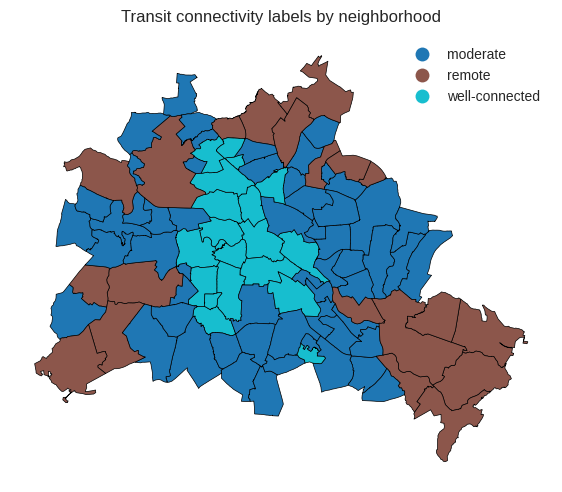

In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd

# --- config you can tweak ---
W_UBAHN, W_BUS = 3.0, 1.0          # weight U-Bahn vs bus/tram
LABEL_Q_LOW, LABEL_Q_HIGH = 0.2, 0.8
LABELS = {"high":"well-connected", "mid":"moderate", "low":"remote"}
AREA_FLOOR_KM2 = 0.05              # just in case any area is missing

# 1) bring exact areas from polygons
areas = gdf_nei[["district_id","neighborhood_id","area_km2"]].copy()
res = counts.merge(areas, on=["district_id","neighborhood_id"], how="left")
res["area_km2"] = res["area_km2"].fillna(AREA_FLOOR_KM2)

# 2) densities + weighted density
res["weighted_stops"] = W_UBAHN*res["ubahn_stations"] + W_BUS*res["bus_tram_stops"]
res["density_total_per_km2"]   = res["total_stops"]   / res["area_km2"]
res["density_ubahn_per_km2"]   = res["ubahn_stations"]/ res["area_km2"]
res["weighted_density_per_km2"] = res["weighted_stops"]/ res["area_km2"]

# 3) labels by quantiles of weighted density
q_low, q_high = res["weighted_density_per_km2"].quantile([LABEL_Q_LOW, LABEL_Q_HIGH])
res["label"] = np.where(res["weighted_density_per_km2"] >= q_high, LABELS["high"],
                 np.where(res["weighted_density_per_km2"] <= q_low, LABELS["low"], LABELS["mid"]))

# 4) tidy view + save
res = res.sort_values(["district","neighborhood"]).reset_index(drop=True)
res.to_csv("neighborhood_counts_densities_labels.csv", index=False)

# quick peek: top/bottom 10 by weighted density
top10 = res.nlargest(10, "weighted_density_per_km2")[["district","neighborhood","weighted_density_per_km2","ubahn_stations","bus_tram_stops","area_km2","label"]]
bot10 = res.nsmallest(10, "weighted_density_per_km2")[["district","neighborhood","weighted_density_per_km2","ubahn_stations","bus_tram_stops","area_km2","label"]]
display(top10); display(bot10)

# 5) quick choropleth (optional)
plot_gdf = gdf_nei.merge(res[["district_id","neighborhood_id","label"]], on=["district_id","neighborhood_id"], how="left")
ax = plot_gdf.plot(column="label", legend=True, figsize=(7,7), linewidth=0.5, edgecolor="black")
ax.set_axis_off()
ax.set_title("Transit connectivity labels by neighborhood", pad=10)


In [13]:
# Interactive choropleth with hover tooltips (Leaflet via GeoPandas.explore)

import geopandas as gpd
import pandas as pd
import numpy as np

# 0) Ensure your polygon GeoDataFrame has exact areas (km²).
#    If not present, compute from geometry in a metric CRS (UTM 33N for Berlin).
if "area_km2" not in gdf_nei.columns:
    gdf_nei = gdf_nei.copy()
    gdf_nei["area_km2"] = gdf_nei.to_crs(25833).area / 1e6  # EPSG:25833 = ETRS89 / UTM 33N

# 1) Bring ONLY non-area attributes from 'res' to avoid duplicate 'area_km2' columns.
#    (Assumes you ran the previous step that created 'res' with these columns.)
attrs = res[[
    "district_id", "neighborhood_id",
    "ubahn_stations", "bus_tram_stops", "total_stops",
    "density_total_per_km2", "weighted_density_per_km2", "label"
]].copy()

# 2) Merge attributes onto polygons.
plot_gdf = gdf_nei.merge(attrs, on=["district_id","neighborhood_id"], how="left")

# 3) Nicely rounded fields for tooltips.
plot_gdf["area_km2_r"]   = plot_gdf["area_km2"].round(2)
plot_gdf["dens_total_r"] = plot_gdf["density_total_per_km2"].round(1)
plot_gdf["dens_w_r"]     = plot_gdf["weighted_density_per_km2"].round(1)

# 4) Interactive map with hover tooltip + click popup.
m = plot_gdf.explore(
    column="label",              # color by label (categorical)
    categorical=True,
    legend=True,
    tooltip=[
        "neighborhood", "district",
        "ubahn_stations", "bus_tram_stops", "total_stops",
        "area_km2_r", "dens_total_r", "dens_w_r"
    ],
    popup=True,                  # click for full record
    highlight=True,              # outline feature on hover
    style_kwds={"weight": 0.6, "fillOpacity": 0.6},
)

# 5) Display in the notebook and save to HTML (shareable).
m
m.save("berlin_transit_connectivity_map.html")
print("Saved: berlin_transit_connectivity_map.html")


Saved: berlin_transit_connectivity_map.html


In [14]:
# === Reliability-aware lines + walking coverage ===

import geopandas as gpd
import pandas as pd
import numpy as np

# -----------------------------
# Config (tune as you like)
# -----------------------------
# weights for stops → density
W_UBAHN = 3.0
W_BUSTRAM = 1.0

# line factors (extra credit per additional line at the same station/stop)
LINE_FACTOR_UBAHN = 0.7
LINE_FACTOR_BUSTRAM = 0.3  # NOTE: applied later when you have line data for bus/tram

# walking coverage radii (meters)
RADIUS_RAIL_M = 750      # U-Bahn (S-Bahn later)
RADIUS_BUS_TRAM_M = 400  # bus/tram

# combine rail vs bus/tram coverage into carless score
COVERAGE_WEIGHT_RAIL = 0.7
COVERAGE_WEIGHT_BUSTRAM = 0.3

# label quantiles for final index (if you want a single headline label)
LABEL_Q_LOW, LABEL_Q_HIGH = 0.2, 0.8
LABELS = {"high":"well-connected", "mid":"moderate", "low":"remote"}

# -----------------------------
# Prep GeoDataFrames
# -----------------------------
# ensure polygons have exact area (km²)
if "area_km2" not in gdf_nei.columns:
    gdf_nei = gdf_nei.copy()
    gdf_nei["area_km2"] = gdf_nei.to_crs(25833).area / 1e6

# points → GeoDataFrames (WGS84)
gub = gpd.GeoDataFrame(
    df_ubahn.copy(),
    geometry=gpd.points_from_xy(df_ubahn["longitude"], df_ubahn["latitude"]),
    crs=4326
)
gbt = gpd.GeoDataFrame(
    df_bus_tram.copy(),
    geometry=gpd.points_from_xy(df_bus_tram["longitude"], df_bus_tram["latitude"]),
    crs=4326
)

# polygon keys we need
poly_keys = ["district_id","district","neighborhood_id","neighborhood","geometry"]
polys = gdf_nei[poly_keys].copy()

# -----------------------------
# 1) Line-aware U-Bahn "effective stations"
# -----------------------------
# Avoid suffix headaches: rename overlapping columns on point side
gub_clean = gub.rename(columns={"district_id":"district_id_pt","district":"district_pt","neighborhood":"neighborhood_pt"})
# spatial join → attach polygon ids to each U-Bahn point
gub_j = gpd.sjoin(gub_clean, polys, how="left", predicate="within")

# count unique lines per (district_id, neighborhood_id, station)
u_lines = (gub_j.dropna(subset=["district_id","neighborhood_id"])
                .groupby(["district_id","neighborhood_id","station"])["line"]
                .nunique()
                .reset_index(name="n_lines"))

# effective station weight per station: 1 + 0.7*(L-1)
u_lines["ubahn_station_effective"] = 1.0 + LINE_FACTOR_UBAHN * (u_lines["n_lines"] - 1.0)

# sum within neighborhood
ubahn_effective = (u_lines.groupby(["district_id","neighborhood_id"])["ubahn_station_effective"]
                        .sum().reset_index())

# -----------------------------
# 2) Plain bus/tram counts (no line data yet)
# -----------------------------
# (reuse your existing counts if you have them; otherwise compute quickly via spatial join)
gbt_clean = gbt.rename(columns={"district_id":"district_id_pt","district":"district_pt","neighborhood":"neighborhood_pt"})
gbt_j = gpd.sjoin(gbt_clean, polys, how="left", predicate="within")

bt_counts = (gbt_j.dropna(subset=["district_id","neighborhood_id"])
                 .groupby(["district_id","neighborhood_id"])
                 .size().reset_index(name="bus_tram_stops"))

# -----------------------------
# 3) Merge with polygons and compute densities
# -----------------------------
# skeleton table from polygons
base = polys.drop(columns="geometry").drop_duplicates()

# merge effective U-Bahn & bus/tram counts
res2 = (base
        .merge(ubahn_effective, on=["district_id","neighborhood_id"], how="left")
        .merge(bt_counts,      on=["district_id","neighborhood_id"], how="left")
        .fillna({"ubahn_station_effective":0.0, "bus_tram_stops":0})
       )

# weighted stops (reliability-aware)
res2["weighted_stops_v2"] = W_UBAHN*res2["ubahn_station_effective"] + W_BUSTRAM*res2["bus_tram_stops"]

# bring areas
areas = gdf_nei[["district_id","neighborhood_id","area_km2"]]
res2 = res2.merge(areas, on=["district_id","neighborhood_id"], how="left")

# densities
res2["weighted_density_v2"] = res2["weighted_stops_v2"] / res2["area_km2"]

# -----------------------------
# 4) Walking coverage (rail 750m, bus/tram 400m)
# -----------------------------
# Project everything to metric CRS for buffering
neigh_25833 = gdf_nei.to_crs(25833)
gub_25833 = gub.to_crs(25833)
gbt_25833 = gbt.to_crs(25833)

# union of buffers (citywide)
rail_buf_union = gub_25833.buffer(RADIUS_RAIL_M).unary_union
bt_buf_union   = gbt_25833.buffer(RADIUS_BUS_TRAM_M).unary_union

# intersect with each neighborhood polygon to measure coverage area
rail_cov_m2 = []
bt_cov_m2   = []
poly_area_m2 = []

for geom in neigh_25833.geometry:
    poly_area = geom.area
    poly_area_m2.append(poly_area)
    rail_cov = geom.intersection(rail_buf_union).area if not rail_buf_union.is_empty else 0.0
    bt_cov   = geom.intersection(bt_buf_union).area   if not bt_buf_union.is_empty   else 0.0
    rail_cov_m2.append(rail_cov)
    bt_cov_m2.append(bt_cov)

cov_df = pd.DataFrame({
    "district_id": gdf_nei["district_id"].values,
    "neighborhood_id": gdf_nei["neighborhood_id"].values,
    "rail_cov_share":  np.array(rail_cov_m2) / np.array(poly_area_m2),
    "bus_cov_share":   np.array(bt_cov_m2)   / np.array(poly_area_m2),
})

# clip numeric issues to [0,1]
cov_df["rail_cov_share"] = cov_df["rail_cov_share"].clip(0,1)
cov_df["bus_cov_share"]  = cov_df["bus_cov_share"].clip(0,1)

# composite "car-free friendliness"
cov_df["carless_score"] = (COVERAGE_WEIGHT_RAIL * cov_df["rail_cov_share"] +
                           COVERAGE_WEIGHT_BUSTRAM * cov_df["bus_cov_share"])

# -----------------------------
# 5) Combine density + coverage into a single index (optional)
# -----------------------------
res2 = res2.merge(cov_df, on=["district_id","neighborhood_id"], how="left")

# z-score helper
def zseries(x):
    s = pd.Series(x)
    std = s.std(ddof=0)
    return (s - s.mean()) / (std if std > 0 else 1.0)

# mix density (structure) and coverage (experience)
res2["final_index"] = 0.6 * zseries(res2["weighted_density_v2"]) + 0.4 * zseries(res2["carless_score"])

# labels based on the final index (or choose to label on density/coverage separately)
q_low, q_high = res2["final_index"].quantile([LABEL_Q_LOW, LABEL_Q_HIGH])
res2["label_v2"] = np.where(res2["final_index"] >= q_high, LABELS["high"],
                     np.where(res2["final_index"] <= q_low, LABELS["low"], LABELS["mid"]))

# tidy
res2 = res2.sort_values(["district","neighborhood"]).reset_index(drop=True)

# peek
display(res2.head(12)[[
    "district","neighborhood",
    "ubahn_station_effective","bus_tram_stops","weighted_stops_v2","area_km2",
    "weighted_density_v2","rail_cov_share","bus_cov_share","carless_score","final_index","label_v2"
]])

print("Done. Columns added:")
print("- ubahn_station_effective: sum over stations of [1 + 0.7*(lines-1)]")
print("- weighted_stops_v2, weighted_density_v2: reliability-aware counts/density")
print("- rail_cov_share (750m), bus_cov_share (400m), carless_score")
print("- final_index + label_v2 (combined density + coverage)")


,district,neighborhood,ubahn_station_effective,bus_tram_stops,weighted_stops_v2,area_km2,weighted_density_v2,rail_cov_share,bus_cov_share,carless_score,final_index,label_v2
0,Charlottenburg-Wilmersdorf,Charlottenburg,14.7,68,112.1,10.591550,10.583909,0.665671,0.939472,0.747811,1.893146,well-connected
1,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,3.0,25,34.0,6.196480,5.486986,0.413447,0.774255,0.521689,0.451427,moderate
2,Charlottenburg-Wilmersdorf,Grunewald,0.0,22,22.0,22.343924,0.984608,0.000000,0.257707,0.077312,-1.223055,remote
3,Charlottenburg-Wilmersdorf,Halensee,0.0,6,6.0,1.266255,4.738383,0.168272,0.915099,0.392321,0.082080,moderate
4,Charlottenburg-Wilmersdorf,Schmargendorf,0.0,17,17.0,3.586366,4.740175,0.125471,0.934156,0.368076,0.042722,moderate
5,Charlottenburg-Wilmersdorf,Westend,3.0,43,52.0,13.520979,3.845875,0.289438,0.679258,0.406384,-0.082431,moderate
6,Charlottenburg-Wilmersdorf,Wilmersdorf,14.2,40,82.6,7.157517,11.540315,0.945816,0.970393,0.953189,2.430737,well-connected
7,Friedrichshain-Kreuzberg,Friedrichshain,5.0,57,72.0,9.944490,7.240190,0.669681,0.980658,0.762974,1.215314,well-connected
8,Friedrichshain-Kreuzberg,Kreuzberg,16.7,73,123.1,10.372039,11.868448,0.828414,0.971332,0.871289,2.365464,well-connected
9,Lichtenberg,Alt-Hohenschönhausen,0.0,38,38.0,9.347575,4.065225,0.000000,0.896205,0.268861,-0.261726,moderate


Done. Columns added:
- ubahn_station_effective: sum over stations of [1 + 0.7*(lines-1)]
- weighted_stops_v2, weighted_density_v2: reliability-aware counts/density
- rail_cov_share (750m), bus_cov_share (400m), carless_score
- final_index + label_v2 (combined density + coverage)


In [15]:
# Quick interactive map of the upgraded metrics (Folium only)

# 0) deps
!pip install -q folium

import folium
import geopandas as gpd
import pandas as pd
import numpy as np

# 1) make sure polygons have area_km2; compute if not
if "area_km2" not in gdf_nei.columns:
    gdf_nei = gdf_nei.copy()
    gdf_nei["area_km2"] = gdf_nei.to_crs(25833).area / 1e6

# 2) bring ONLY non-area attrs from res2 to avoid suffix clashes
attrs = res2[[
    "district_id","neighborhood_id",
    "ubahn_station_effective","bus_tram_stops","weighted_stops_v2",
    "weighted_density_v2","rail_cov_share","bus_cov_share","carless_score",
    "final_index","label_v2"
]].copy()

plot_gdf2 = gdf_nei.merge(attrs, on=["district_id","neighborhood_id"], how="left").copy()

# Drop the 'centroid' column as it's not JSON serializable for Folium GeoJson properties
if 'centroid' in plot_gdf2.columns:
    plot_gdf2 = plot_gdf2.drop(columns=['centroid'])

# 3) tidy/rounded fields for tooltips
plot_gdf2["area_km2_r"] = plot_gdf2["area_km2"].round(2)
plot_gdf2["dens_w_r"]   = plot_gdf2["weighted_density_v2"].round(1)
plot_gdf2["rail_cov_pct"] = (plot_gdf2["rail_cov_share"]*100).round(0).astype("Int64")
plot_gdf2["bus_cov_pct"]  = (plot_gdf2["bus_cov_share"]*100).round(0).astype("Int64")
plot_gdf2["carless_r"]    = (plot_gdf2["carless_score"]*100).round(0).astype("Int64")

# 4) colors for categories
color_map = {
    "well-connected": "#1a9641",  # green
    "moderate":       "#fee08b",  # yellow
    "remote":         "#d73027",  # red
}
default_fill = "#cccccc"

def style_function(feature):
    lbl = feature["properties"].get("label_v2")
    return {
        "fillColor": color_map.get(lbl, default_fill),
        "color": "#555555",
        "weight": 0.6,
        "fillOpacity": 0.6,
    }

tooltip_fields = [
    "neighborhood","district",
    "ubahn_station_effective","bus_tram_stops","weighted_stops_v2",
    "area_km2_r","dens_w_r",
    "rail_cov_pct","bus_cov_pct","carless_r",
    "label_v2"
]
tooltip_aliases = [
    "Neighborhood","District",
    "Eff. U-Bahn stations","Bus/Tram stops","Weighted stops (v2)",
    "Area (km²)","Weighted density (/km²)",
    "Rail coverage (%)","Bus/Tram coverage (%)","Carless score (%)",
    "Label (v2)"
]

# 5) build map
m = folium.Map(location=[52.52, 13.405], zoom_start=10, tiles="cartodbpositron")

gj = folium.GeoJson(
    data=plot_gdf2.to_crs(4326).to_json(),
    name="Transit connectivity (v2)",
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(fields=tooltip_fields, aliases=tooltip_aliases, sticky=True),
    popup=folium.features.GeoJsonPopup(fields=tooltip_fields, labels=True),
).add_to(m)

# category legend
legend_html = """
<div style="
  position: fixed; bottom: 20px; left: 20px; z-index: 9999;
  background: white; padding: 10px 12px; border-radius: 8px;
  box-shadow: 0 0 10px rgba(0,0,0,0.15); font-size: 12px;">
  <div style="font-weight:600; margin-bottom:6px;">Label (v2)</div>
  <div><span style="background:#1a9641; width:12px; height:12px; display:inline-block; margin-right:6px;"></span>well-connected</div>
  <div><span style="background:#fee08b; width:12px; height:12px; display:inline-block; margin-right:6px; border:1px solid #ccc;"></span>moderate</div>
  <div><span style="background:#d73027; width:12px; height:12px; display:inline-block; margin-right:6px;"></span>remote</div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)

# 6) display & save
m
m.save("berlin_transit_connectivity_map_v2.html")
print("Saved: berlin_transit_connectivity_map_v2.html")

Saved: berlin_transit_connectivity_map_v2.html


In [16]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from shapely.geometry import Point

# Ensure polygons have area in km²
if "area_km2" not in gdf_nei.columns:
    gdf_nei = gdf_nei.copy()
    gdf_nei["area_km2"] = gdf_nei.to_crs(25833).area / 1e6

# Save polygons once (good for Streamlit too)
gdf_nei.to_crs(4326)[["district_id","district","neighborhood_id","neighborhood","geometry"]].to_file(
    "neighborhoods.geojson", driver="GeoJSON"
)
gdf_nei[["district_id","neighborhood_id","area_km2"]].to_csv("neighborhood_base_areas.csv", index=False)

def to_points_gdf(df, lon="longitude", lat="latitude", crs=4326):
    g = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[lon], df[lat]), crs=crs)
    return g

def coverage_share_by_points(points_gdf, neighborhoods_gdf, radius_m):
    pts = points_gdf.to_crs(25833)
    nbh = neighborhoods_gdf.to_crs(25833)
    buf_union = pts.buffer(radius_m).unary_union
    shares = []
    for geom in nbh.geometry:
        a = geom.area
        inter = geom.intersection(buf_union).area if not buf_union.is_empty else 0.0
        shares.append(inter / a if a > 0 else 0.0)
    out = neighborhoods_gdf[["district_id","neighborhood_id"]].copy()
    out["coverage_share"] = np.clip(shares, 0, 1)
    return out

def coverage_share_by_polygons(polys_gdf, neighborhoods_gdf, buffer_m=0):
    src = polys_gdf.to_crs(25833)
    if buffer_m and buffer_m > 0:
        src = src.copy()
        src["geometry"] = src.buffer(buffer_m)
    union = src.unary_union
    nbh = neighborhoods_gdf.to_crs(25833)
    shares = []
    for geom in nbh.geometry:
        a = geom.area
        inter = geom.intersection(union).area if not union.is_empty else 0.0
        shares.append(inter / a if a > 0 else 0.0)
    out = neighborhoods_gdf[["district_id","neighborhood_id"]].copy()
    out["coverage_share"] = np.clip(shares, 0, 1)
    return out

def label_by_thresholds(x, low, high, names=("low","moderate","high")):
    return np.where(x >= high, names[2], np.where(x <= low, names[0], names[1]))

def save_folium_map(plot_gdf, label_col, html_name, palette=None):
    palette = palette or {"high":"#1a9641","moderate":"#fee08b","low":"#d73027"}
    def style_fn(feat):
        lab = feat["properties"].get(label_col)
        return {"fillColor": palette.get(lab, "#cccccc"), "color": "#555", "weight": 0.6, "fillOpacity": 0.65}
    m = folium.Map(location=[52.52, 13.405], zoom_start=10, tiles="cartodbpositron")
    gj = folium.GeoJson(
        data=plot_gdf.to_crs(4326).to_json(),
        style_function=style_fn,
        tooltip=folium.features.GeoJsonTooltip(
            fields=["neighborhood","district", label_col],
            aliases=["Neighborhood","District", label_col],
            sticky=True
        ),
        popup=folium.features.GeoJsonPopup(fields=[label_col], labels=True),
    )
    gj.add_to(m)
    folium.LayerControl().add_to(m)
    m.save(html_name)
    print("Saved:", html_name)


In [17]:
path_4 = path + "/parks.csv"
df_parks = pd.read_csv(path_4)
print(df_parks.head())
print(df_parks.columns.to_list())

        technical_id                key object_number  district_id  \
0  00008100_001042bb  00008100:001042bb         00037     11012012   
1  00008100_00104621  00008100:00104621         01179     11012012   
2  00008100_001044bd  00008100:001044bd         01074     11012012   
3  00008100_00104620  00008100:00104620         01180     11012012   
4  00008100_00104438  00008100:00104438         00476     11012012   

        district   neighborhood type_of_green_space  \
0  Reinickendorf        Frohnau          Grünanlage   
1  Reinickendorf         Lübars          Grünanlage   
2  Reinickendorf      Hermsdorf          Grünanlage   
3  Reinickendorf         Lübars          Grünanlage   
4  Reinickendorf  Reinickendorf          Grünanlage   

                                    green_space_name        name_extension  \
0                        Im Fischgrund, "Rosenanger"            Rosenanger   
1                  Klötzbecken bis Zabel-Krüger-Damm  einschl. Klötzbecken   
2  Heidenheime

In [18]:
# === Park share only: median-based labels + map ===
import re, numpy as np, pandas as pd, geopandas as gpd, folium

# CONFIG
GREEN_SHARE_MEDIAN_BAND = 0.03   # ±3 percentage points around the median -> "average"
BOROUGH_WISE = False             # set True to use medians per district (borough)
CSV_OUT = "features_green_share_only.csv"
MAP_HTML = "map_green_share_median.html"

def canon_nh(x: str) -> str:
    if pd.isna(x): return x
    s = str(x).strip().lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    return re.sub(r"[^a-z0-9]+","", s)

def three_band_label(val, med, band):
    if pd.isna(val): return "average"
    if (med - band) <= val <= (med + band): return "average"
    return "above average" if val > (med + band) else "below average"

# 1) Aggregate park area per (district_id, neighborhood)
parks = df_parks.copy()
parks["neighborhood_canon"] = parks["neighborhood"].map(canon_nh)
parks["size_sqm"] = pd.to_numeric(parks["size_sqm"], errors="coerce").fillna(0.0)
parks_agg = (parks.groupby(["district_id","neighborhood_canon"], dropna=False)["size_sqm"]
                  .sum().reset_index(name="green_area_sqm"))
parks_agg["green_area_km2"] = parks_agg["green_area_sqm"] / 1e6

# 2) Join to polygons and compute share
nei = gdf_nei[["district_id","district","neighborhood_id","neighborhood","area_km2","geometry"]].copy()
nei["neighborhood_canon"] = nei["neighborhood"].map(canon_nh)
green = nei.merge(parks_agg, on=["district_id","neighborhood_canon"], how="left") \
           .fillna({"green_area_sqm":0.0,"green_area_km2":0.0})
green["green_share"] = (green["green_area_km2"] / green["area_km2"]).clip(0,1)

# 3) Median-based labels (citywide or per borough)
if BOROUGH_WISE:
    med = green.groupby("district")["green_share"].transform("median")
    green["green_share_label"] = [three_band_label(v, m, GREEN_SHARE_MEDIAN_BAND) for v, m in zip(green["green_share"], med)]
else:
    med = float(np.nanmedian(green["green_share"]))
    green["green_share_label"] = [three_band_label(v, med, GREEN_SHARE_MEDIAN_BAND) for v in green["green_share"]]

# 4) Save CSV
green[[
    "district_id","district","neighborhood_id","neighborhood","area_km2",
    "green_area_km2","green_share","green_share_label"
]].to_csv(CSV_OUT, index=False)
print("Saved:", CSV_OUT)

# 5) HTML map
palette = {"above average":"#1a9641","average":"#fee08b","below average":"#d73027"}
def style_fn(feat):
    lab = feat["properties"].get("green_share_label")
    return {"fillColor": palette.get(lab, "#cccccc"), "color":"#555", "weight":0.6, "fillOpacity":0.65}

plot = green.copy()
plot["green_share_pct"] = (plot["green_share"]*100).round(1)

m = folium.Map(location=[52.52, 13.405], zoom_start=10, tiles="cartodbpositron")
folium.GeoJson(
    data=plot.to_crs(4326).to_json(),
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["neighborhood","district","green_share_pct","green_share_label"],
        aliases=["Neighborhood","District","Green share (%)","Label"],
        sticky=True
    ),
).add_to(m)
folium.LayerControl().add_to(m)
m.save(MAP_HTML)
print("Saved:", MAP_HTML)


Saved: features_green_share_only.csv
Saved: map_green_share_median.html


In [19]:
path_5 = path + "/playgrounds.csv"
df_playgrounds = pd.read_csv(path_5)
print(df_playgrounds.head())
print(df_playgrounds.columns.to_list())

        technical_id                key object_number  district_id  \
0  00008100_002f2c6b  00008100:002f2c6b         19441     11007007   
1  00008100_0033cfac  00008100:0033cfac         35098     11012012   
2  00008100_0032a99a  00008100:0032a99a        21AS10     11011011   
3  00008100_00199411  00008100:00199411         00156     11010010   
4  00008100_00281623  00008100:00281623        150072     11009009   

               district neighborhood green_area_type  \
0  Tempelhof-Schöneberg  Lichtenrade      Spielplatz   
1         Reinickendorf        Tegel      Spielplatz   
2           Lichtenberg  Lichtenberg      Spielplatz   
3   Marzahn-Hellersdorf      Marzahn      Spielplatz   
4      Treptow-Köpenick  Schmöckwitz      Spielplatz   

                                   playground_name  \
0                                     Nuthestr. 26   
1                        Borsigdamm 4 (Spielplatz)   
2                         Gudrunstr. 14 Spielplatz   
3         Hohenwalder/Scho

In [20]:
# === Playgrounds: density (per km²) → median-based labels → HTML map ===
import re, numpy as np, pandas as pd, geopandas as gpd, folium

# ---- CONFIG ----
AREA_FLOOR_KM2 = 0.20        # guard: treat very tiny polygons as at least this size
DENSITY_MEDIAN_BAND = 0.30   # ± band around the median density → "average"
BOROUGH_WISE = False         # True = median per district (borough)
CSV_OUT = "features_playgrounds_density.csv"
MAP_HTML = "map_playgrounds_density.html"

def canon_nh(x: str) -> str:
    if pd.isna(x): return x
    s = str(x).strip().lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    return re.sub(r"[^a-z0-9]+", "", s)

def three_band_label(val, med, band):
    if pd.isna(val): return "average"
    if (med - band) <= val <= (med + band): return "average"
    return "above average" if val > (med + band) else "below average"

# 1) Filter to playgrounds and normalize names
dfp = df_playgrounds.copy()
dfp = dfp[dfp["green_area_type"].str.contains("spielplatz", case=False, na=False)].copy()
dfp["neighborhood_canon"] = dfp["neighborhood"].map(canon_nh)

# 2) Count per (district_id, neighborhood_canon)
pg_counts = (dfp.groupby(["district_id","neighborhood_canon"], dropna=False)
                .size().reset_index(name="n_playgrounds"))

# 3) Join to polygons, bring area, compute density
nei = gdf_nei[["district_id","district","neighborhood_id","neighborhood","area_km2","geometry"]].copy()
# ensure area_km2 exists; compute if missing
if "area_km2" not in nei.columns or nei["area_km2"].isna().any():
    nei = gdf_nei[["district_id","district","neighborhood_id","neighborhood","geometry"]].copy()
    nei["area_km2"] = gdf_nei.to_crs(25833).area / 1e6

nei["neighborhood_canon"] = nei["neighborhood"].map(canon_nh)

play = (nei.merge(pg_counts, on=["district_id","neighborhood_canon"], how="left")
            .fillna({"n_playgrounds":0}))
play["n_playgrounds"] = play["n_playgrounds"].astype(int)

# apply area floor to avoid extreme densities for tiny polygons
play["area_eff_km2"] = np.maximum(play["area_km2"].astype(float), AREA_FLOOR_KM2)
play["playgrounds_per_km2"] = play["n_playgrounds"] / play["area_eff_km2"]

# 4) Median-based labels (citywide or per borough)
if BOROUGH_WISE:
    med_series = play.groupby("district")["playgrounds_per_km2"].transform("median")
    play["playgrounds_density_label"] = [
        three_band_label(v, m, DENSITY_MEDIAN_BAND) for v, m in zip(play["playgrounds_per_km2"], med_series)
    ]
else:
    med = float(np.nanmedian(play["playgrounds_per_km2"]))
    play["playgrounds_density_label"] = [
        three_band_label(v, med, DENSITY_MEDIAN_BAND) for v in play["playgrounds_per_km2"]
    ]

# 5) Save CSV for later merging into the master features table / app
play[[
    "district_id","district","neighborhood_id","neighborhood",
    "n_playgrounds","area_km2","area_eff_km2","playgrounds_per_km2",
    "playgrounds_density_label"
]].to_csv(CSV_OUT, index=False)
print("Saved:", CSV_OUT)

# 6) HTML map (categorical)
palette = {"above average":"#1a9641","average":"#fee08b","below average":"#d73027"}
def style_fn(feat):
    lab = feat["properties"].get("playgrounds_density_label")
    return {"fillColor": palette.get(lab, "#cccccc"), "color":"#555", "weight":0.6, "fillOpacity":0.65}

# round for tooltips
plot = play.copy()
plot["pg_per_km2_r"] = plot["playgrounds_per_km2"].round(2)

m = folium.Map(location=[52.52, 13.405], zoom_start=10, tiles="cartodbpositron")
folium.GeoJson(
    data=plot.to_crs(4326).to_json(),
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(
        fields=["neighborhood","district","n_playgrounds","pg_per_km2_r","playgrounds_density_label"],
        aliases=["Neighborhood","District","# Playgrounds","Per km²","Label"],
        sticky=True
    ),
).add_to(m)
folium.LayerControl().add_to(m)
m.save(MAP_HTML)
print("Saved:", MAP_HTML)


Saved: features_playgrounds_density.csv
Saved: map_playgrounds_density.html


In [21]:
import re, numpy as np, pandas as pd, geopandas as gpd

# ===== helpers =====
def canon_nh(x: str) -> str:
    if pd.isna(x): return x
    s = str(x).strip().lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    return re.sub(r"[^a-z0-9]+","", s)

def three_band_label(val, med, band):
    if pd.isna(val): return "average"
    if (med - band) <= val <= (med + band): return "average"
    return "above average" if val > (med + band) else "below average"

# ===== base polygons + area + centroids =====
g = gdf_nei[["district_id","district","neighborhood_id","neighborhood","geometry"]].copy()
if "area_km2" not in g.columns or g["area_km2"].isna().any():
    g = g.copy()
    g["area_km2"] = g.to_crs(25833).area / 1e6
g_wgs = g.to_crs(4326)
cent = g_wgs.geometry.centroid
g["centroid_lon"] = cent.x.round(6)
g["centroid_lat"] = cent.y.round(6)
g["neighborhood_canon"] = g["neighborhood"].map(canon_nh)

# ===== mobility label (from your latest res2) =====
mob = res2[["district_id","neighborhood_id","label_v2"]].rename(columns={"label_v2":"mobility_label"})

# ===== parks → green share (median-based label) =====
parks = df_parks.copy()
parks["neighborhood_canon"] = parks["neighborhood"].map(canon_nh)
parks["size_sqm"] = pd.to_numeric(parks["size_sqm"], errors="coerce").fillna(0.0)
parks_agg = (parks.groupby(["district_id","neighborhood_canon"], dropna=False)["size_sqm"]
                  .sum().reset_index(name="green_area_sqm"))
parks_agg["green_area_km2"] = parks_agg["green_area_sqm"] / 1e6

green = g[["district_id","neighborhood_id","neighborhood","neighborhood_canon","area_km2"]].merge(
    parks_agg, on=["district_id","neighborhood_canon"], how="left"
).fillna({"green_area_sqm":0.0,"green_area_km2":0.0})
green["green_share"] = (green["green_area_km2"] / green["area_km2"]).clip(0,1)
med_share = float(np.nanmedian(green["green_share"]))
green["green_share_label"] = [three_band_label(v, med_share, 0.03) for v in green["green_share"]]
green = green[["district_id","neighborhood_id","green_share","green_share_label"]]

# ===== playgrounds → density per km² (median-based label) =====
pg = df_playgrounds.copy()
pg = pg[pg["green_area_type"].str.contains("spielplatz", case=False, na=False)].copy()
pg["neighborhood_canon"] = pg["neighborhood"].map(canon_nh)
pg_counts = (pg.groupby(["district_id","neighborhood_canon"], dropna=False)
               .size().reset_index(name="n_playgrounds"))

play = g[["district_id","neighborhood_id","neighborhood","neighborhood_canon","area_km2"]].merge(
    pg_counts, on=["district_id","neighborhood_canon"], how="left"
).fillna({"n_playgrounds":0})
play["n_playgrounds"] = play["n_playgrounds"].astype(int)
AREA_FLOOR_KM2 = 0.20
play["area_eff_km2"] = np.maximum(play["area_km2"].astype(float), AREA_FLOOR_KM2)
play["playgrounds_per_km2"] = play["n_playgrounds"] / play["area_eff_km2"]
med_dens = float(np.nanmedian(play["playgrounds_per_km2"]))
play["playgrounds_density_label"] = [three_band_label(v, med_dens, 0.30) for v in play["playgrounds_per_km2"]]
play = play[["district_id","neighborhood_id","n_playgrounds","playgrounds_per_km2","playgrounds_density_label"]]

# ===== assemble one tidy table =====
labels = (g.drop(columns=["geometry","neighborhood_canon"])
            .merge(mob,   on=["district_id","neighborhood_id"], how="left")
            .merge(green, on=["district_id","neighborhood_id"], how="left")
            .merge(play,  on=["district_id","neighborhood_id"], how="left"))

labels = labels.sort_values(["district","neighborhood"]).reset_index(drop=True)

# save CSV for Streamlit
labels.to_csv("neighborhood_labels_minimal.csv", index=False)
print("Saved: neighborhood_labels_minimal.csv")

# save polygons GeoJSON (referenced by Streamlit)
g_wgs[["district_id","district","neighborhood_id","neighborhood","geometry"]].to_file(
    "neighborhoods.geojson", driver="GeoJSON"
)
print("Saved: neighborhoods.geojson")


Saved: neighborhood_labels_minimal.csv
Saved: neighborhoods.geojson


# Venues

In [22]:
path_6 = path + "/venues.csv"
df_venues = pd.read_csv(path_6)
#print(df_venues.head())
print(df_venues.columns.to_list())
print(df_venues["cuisine"].value_counts())

['venue_id', 'district_id', 'name', 'district', 'category', 'cuisine', 'phone', 'address', 'latitude', 'longitude', 'website', 'opening_hours_dict', 'opening_hours', 'postal_code', 'neighborhood', 'takeaway', 'wheelchair_accessible']
cuisine
italian                       624
coffee_shop                   270
vietnamese                    268
german                        242
asian                         218
                             ... 
austrian;oriental               1
italian;pizza;burger;pasta      1
fish;mediterranean              1
chinese;japanese                1
bavarian;sausage                1
Name: count, Length: 680, dtype: int64


In [23]:
# --- National cuisines only: config + tokenizer (English-only) ---

import re

# Master vocabulary: national / regional cuisines we will keep
NATIONAL_CUISINES = {
    # Europe
    "italian","french","spanish","portuguese","greek","turkish","german","austrian","swiss",
    "polish","czech","hungarian","romanian","bulgarian","serbian","croatian","bosnian",
    "slovenian","albanian","georgian","armenian","russian","ukrainian","baltic","scandinavian",
    "british","irish","belgian","dutch",
    # Middle East & North Africa
    "lebanese","syrian","israeli","palestinian","iranian","persian","iraqi","afghan",
    "moroccan","tunisian","algerian","egyptian","middle_eastern","mediterranean",
    # Sub-Saharan Africa
    "ethiopian","eritrean","nigerian","ghanaian","african",
    # South & Southeast Asia
    "indian","pakistani","bangladeshi","sri_lankan","nepalese",
    "thai","vietnamese","laotian","cambodian","indonesian","malaysian","singaporean","filipino","philippine",
    # East Asia
    "japanese","chinese","korean","taiwanese",
    # The Americas
    "mexican","peruvian","argentinian","brazilian","chilean","colombian","caribbean","latin_american",
    "american","canadian",
    # Oceania (rare but included)
    "australian","new_zealand",
}

# Optional synonyms → canonical national tokens
NATIONAL_SYNONYMS = {
    "persian":"iranian",
    "philippine":"filipino",
    "latino":"latin_american",
    "mediterranean":"mediterranean",
    "middle eastern":"middle_eastern",
    "new zealand":"new_zealand",
    # common hyphen/space variants
    "sri lankan":"sri_lankan", "sri-lankan":"sri_lankan",
    "latin american":"latin_american", "latin-american":"latin_american",
    "eastern european":"eastern_european", "eastern-european":"eastern_european",
}

# Tokens we explicitly ignore (street food, dishes, venue types, generics)
IGNORE_TOKENS = {
    "pizza","pasta","risotto","sushi","ramen","dumplings","dim_sum","hot_pot","bao","noodle","noodles",
    "taco","tacos","burrito","quesadilla","arepa","empanada",
    "kebab","doner","döner","shawarma","falafel","mezze","gyro","gyros","souvlaki",
    "schnitzel","wiener_schnitzel","currywurst","sausage","burger","bbq","barbecue","fried_chicken",
    "seafood","steak","fish","crepe","tapas","paella","pho","banh_mi","spring_rolls","bun","biryani","naan","tandoori","curry",
    "coffee_shop","ice_cream","cake","breakfast","sandwich","dessert","bubble_tea",
    # very generic / regional umbrellas (drop unless listed as national above)
    "asian","regional","international","african","latin_american","eastern_european","mediterranean","middle_eastern",
}

def _norm_token(tok: str) -> str:
    t = tok.strip().lower()
    t = t.replace("&","and")
    t = re.sub(r"[^\w\s-]+","", t)
    t = re.sub(r"\s+"," ", t).strip()
    t = t.replace(" ","_")
    # synonyms to canonical
    t = NATIONAL_SYNONYMS.get(t, t)
    return t

def national_tokens_only(val: str) -> list[str]:
    """
    Split a ';'-separated cuisine string, normalize, and return ONLY national cuisine tokens.
    Anything not in NATIONAL_CUISINES is dropped.
    If a venue lists multiple national cuisines, all are kept.
    """
    if val is None or not str(val).strip():
        return []
    raw = [x for x in re.split(r"\s*;\s*", str(val)) if x and x.strip()]
    toks = {_norm_token(x) for x in raw}
    # drop explicit ignore tokens first
    toks -= IGNORE_TOKENS
    # keep only nationals
    nationals = sorted(t for t in toks if t in NATIONAL_CUISINES)
    return nationals

def canon_nh(x: str) -> str:
    if x is None: return ""
    s = str(x).strip().lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    return re.sub(r"[^a-z0-9]+","", s)


In [24]:
# --- Aggregate per neighborhood: venues per km² AND national-cuisine diversity ---

import numpy as np
import pandas as pd
import geopandas as gpd

AREA_FLOOR_KM2 = 0.20  # guard tiny polygons

# 0) Neighborhood base with area
g = gdf_nei[["district_id","district","neighborhood_id","neighborhood","geometry"]].copy()
if "area_km2" not in g.columns or g["area_km2"].isna().any():
    g["area_km2"] = g.to_crs(25833).area / 1e6
g["area_eff_km2"] = np.maximum(g["area_km2"].astype(float), AREA_FLOOR_KM2)
g["neighborhood_canon"] = g["neighborhood"].map(canon_nh)

# 1) Prepare venues
COL_CUISINE = "cuisine"
if COL_CUISINE not in df_venues.columns:
    for alt in ("cuisines","cuisine_type","categories","tags"):
        if alt in df_venues.columns:
            COL_CUISINE = alt
            break

ven = df_venues.copy()
# tokenize to national cuisines ONLY
ven["national_tokens"] = ven[COL_CUISINE].apply(national_tokens_only)

# key join on (district_id + normalized neighborhood name)
ven["neighborhood_canon"] = ven["neighborhood"].map(canon_nh) if "neighborhood" in ven.columns else ""
ven_j = ven.merge(
    g[["district_id","neighborhood_id","neighborhood_canon"]],
    on=["district_id","neighborhood_canon"],
    how="left",
    validate="m:1",
)

# 2) Count total venues per neighborhood
n_ven = (ven_j.groupby(["district_id","neighborhood_id"])
              .size().reset_index(name="n_venues"))

# 3) Distinct national cuisines per neighborhood
atoms = (ven_j.explode("national_tokens")
               .dropna(subset=["national_tokens","neighborhood_id"]))
div_nei = (atoms.groupby(["district_id","neighborhood_id"])["national_tokens"]
                 .nunique()
                 .reset_index(name="n_national_cuisines"))

# 4) Merge & compute density
out = (g[["district_id","district","neighborhood_id","neighborhood","area_km2","area_eff_km2"]]
         .merge(n_ven, on=["district_id","neighborhood_id"], how="left")
         .merge(div_nei, on=["district_id","neighborhood_id"], how="left"))

out[["n_venues","n_national_cuisines"]] = out[["n_venues","n_national_cuisines"]].fillna(0).astype(int)
out["venues_per_km2"] = (out["n_venues"] / out["area_eff_km2"]).round(3)

# 5) Save for the next step (vibrancy / maps)
out.to_csv("features_venues_nationals.csv", index=False)
print("Saved: features_venues_nationals.csv")

# quick peek
display(out.sort_values(["n_national_cuisines","venues_per_km2"], ascending=False)
          .head(15)[["district","neighborhood","n_national_cuisines","n_venues","venues_per_km2","area_km2"]])


Saved: features_venues_nationals.csv


,district,neighborhood,n_national_cuisines,n_venues,venues_per_km2,area_km2
7,Friedrichshain-Kreuzberg,Kreuzberg,37,748,72.117,10.372039
21,Charlottenburg-Wilmersdorf,Charlottenburg,34,782,73.832,10.591550
8,Pankow,Prenzlauer Berg,34,667,60.617,11.003473
64,Neukölln,Neukölln,30,521,44.544,11.696335
49,Tempelhof-Schöneberg,Schöneberg,30,438,41.175,10.637420
6,Friedrichshain-Kreuzberg,Friedrichshain,29,531,53.396,9.944490
0,Mitte,Mitte,28,950,89.005,10.673582
22,Charlottenburg-Wilmersdorf,Wilmersdorf,22,261,36.465,7.157517
1,Mitte,Moabit,22,233,30.238,7.705435
5,Mitte,Gesundbrunnen,15,149,24.332,6.123739


In [26]:
# === Venues Vibrancy Index (citywide, terciles) — robust merge/cleanup ===
import numpy as np
import pandas as pd
import geopandas as gpd
import folium

# -------------------
# Config (tweakable)
# -------------------
WEIGHT_V = 0.65                 # venues density weight
WEIGHT_C = 0.35                 # cuisine diversity weight
ELIG_MIN_VENUES = 10            # eligibility gate: minimum venues
ELIG_MIN_V_PER_KM2 = 2.0        # eligibility gate: minimum venues per km²
IN_CSV = "features_venues_nationals.csv"
OUT_CSV = "features_venues_vibrancy.csv"
OUT_HTML = "map_venues_vibrancy.html"

# -------------------
# 1) Load features & polygons
# -------------------
feat = pd.read_csv(IN_CSV)

need_cols = {"district_id","neighborhood_id","area_km2","area_eff_km2","n_venues","n_national_cuisines"}
missing = need_cols - set(feat.columns)
if missing:
    raise ValueError(f"{IN_CSV} is missing columns: {missing}")

# compute venues per km² if not present
if "venues_per_km2" not in feat.columns:
    feat["venues_per_km2"] = feat["n_venues"] / feat["area_eff_km2"]

poly = gdf_nei[["district_id","district","neighborhood_id","neighborhood","geometry"]].copy()

# robust merge with explicit suffixes, then canonicalize names
g = poly.merge(feat, on=["district_id","neighborhood_id"], how="left", suffixes=("_poly","_feat"))

def coalesce_col(df, base, left_suf="_poly", right_suf="_feat"):
    if base in df.columns:
        return df[base]
    left = base + left_suf
    right = base + right_suf
    if left in df.columns or right in df.columns:
        return df[left] if left in df.columns else df[right]
    # fall back to _x/_y if those exist
    if base + "_x" in df.columns or base + "_y" in df.columns:
        return df[base + "_x"] if base + "_x" in df.columns else df[base + "_y"]
    return pd.Series([np.nan]*len(df))

g["district"] = coalesce_col(g, "district")
g["neighborhood"] = coalesce_col(g, "neighborhood")

# drop any duplicate name columns now that we’ve canonicalized
drop_dupes = [c for c in g.columns if c.endswith(("_poly","_feat","_x","_y")) and c not in ("geometry")]
g = g.drop(columns=drop_dupes)

# -------------------
# 2) Scale to scores (0–100) with robust p10–p90 caps (citywide)
# -------------------
def pscore(series, p_lo=10, p_hi=90):
    s = series.astype(float)
    lo, hi = np.nanpercentile(s, [p_lo, p_hi])
    return np.clip((s - lo) / (hi - lo + 1e-9), 0, 1) * 100.0

g["V_score"] = pscore(g["venues_per_km2"], 10, 90)
g["C_score"] = pscore(g["n_national_cuisines"], 10, 90)

# -------------------
# 3) Composite & labels (citywide terciles)
# -------------------
g["VV_index"] = WEIGHT_V * g["V_score"] + WEIGHT_C * g["C_score"]

eligible = (g["n_venues"] >= ELIG_MIN_VENUES) & (g["venues_per_km2"] >= ELIG_MIN_V_PER_KM2)

q33, q67 = np.nanpercentile(g["VV_index"], [33, 67])
def label_row(idx, elig):
    if pd.isna(idx):
        return "average"
    if elig and idx >= q67:
        return "vibrant"
    if idx <= q33:
        return "sparse"
    return "average"

g["vibrancy_label"] = [label_row(idx, el) for idx, el in zip(g["VV_index"], eligible)]

# -------------------
# 4) Save CSV
# -------------------
save_cols = [
    "district_id","district","neighborhood_id","neighborhood",
    "area_km2","area_eff_km2","n_venues","venues_per_km2","n_national_cuisines",
    "V_score","C_score","VV_index","vibrancy_label"
]
g.drop(columns="geometry").to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

# -------------------
# 5) HTML map (continuous index + tooltip)
# -------------------
def color_scale(value, vmin, vmax):
    if value is None or pd.isna(value): return "#cccccc"
    t = (value - vmin) / (vmax - vmin + 1e-9)
    t = max(0.0, min(1.0, t))
    # red (low) → yellow → green (high)
    if t < 0.5:
        a = t/0.5
        r = int((1-a)*214 + a*255); g = int((1-a)*48 + a*221); b = int((1-a)*49 + a*87)
    else:
        a = (t-0.5)/0.5
        r = int((1-a)*255 + a*26); g = int((1-a)*221 + a*150); b = int((1-a)*87 + a*65)
    return f"#{r:02x}{g:02x}{b:02x}"

vmin = float(np.nanpercentile(g["VV_index"], 5))
vmax = float(np.nanpercentile(g["VV_index"], 95))

def style_fn(feat):
    val = feat["properties"].get("VV_index")
    return {"fillColor": color_scale(val, vmin, vmax), "color":"#555", "weight":0.7, "fillOpacity":0.65}

plot = g.copy()
plot["venues_per_km2_r"] = plot["venues_per_km2"].round(2)
plot["VV_index_r"] = plot["VV_index"].round(1)
plot["V_score_r"] = plot["V_score"].round(0)
plot["C_score_r"] = plot["C_score"].round(0)

m = folium.Map(location=[52.52, 13.405], zoom_start=10, tiles="cartodbpositron")
folium.GeoJson(
    data=plot.to_crs(4326).to_json(),
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(
        fields=[
            "neighborhood","district","vibrancy_label",
            "n_venues","venues_per_km2_r","n_national_cuisines",
            "V_score_r","C_score_r","VV_index_r"
        ],
        aliases=[
            "Neighborhood","District","Label",
            "# Venues","Venues/km²","# Cuisines",
            "Density score","Diversity score","Index"
        ],
        sticky=True
    ),
).add_to(m)

legend = """
<div style="position:fixed; bottom:20px; left:20px; z-index:9999; background:white;
            padding:8px 10px; border-radius:8px; box-shadow:0 0 8px rgba(0,0,0,.2); font-size:12px;">
  <div style="font-weight:600; margin-bottom:6px;">Venues Vibrancy Index</div>
  <div>Color = index (p5→p95)</div>
  <div>Label = citywide terciles + eligibility</div>
</div>"""
m.get_root().html.add_child(folium.Element(legend))

m.save(OUT_HTML)
print("Saved:", OUT_HTML)

Saved: features_venues_vibrancy.csv
Saved: map_venues_vibrancy.html


In [28]:
# Merge venues vibrancy fields into your existing neighborhood labels CSV
import pandas as pd
import numpy as np

LABELS_CSV = "neighborhood_labels_minimal.csv"   # from earlier step
VENUES_CSV = "features_venues_vibrancy.csv"      # from the vibrancy step
OUT_CSV    = "neighborhood_labels_with_venues.csv"

labels = pd.read_csv(LABELS_CSV)
venues = pd.read_csv(VENUES_CSV)

# Sanity: required keys
need = {"district_id","neighborhood_id"}
if not need.issubset(labels.columns) or not need.issubset(venues.columns):
    raise ValueError(f"Both CSVs must have keys {need}. Got:\n"
                     f"labels: {sorted(labels.columns)}\n"
                     f"venues: {sorted(venues.columns)}")

# Select only the venues columns we want to add
ven_add = venues[[
    "district_id","neighborhood_id",
    "n_venues","venues_per_km2","n_national_cuisines",
    "V_score","C_score","VV_index","vibrancy_label"
]].copy()

# Merge (left join keeps all neighborhoods from labels CSV)
merged = labels.merge(ven_add, on=["district_id","neighborhood_id"], how="left", suffixes=("","_venues"))

# If duplicate name columns ever appear, coalesce them safely
def coalesce(df, base, alt):
    if base in df.columns and alt in df.columns:
        df[base] = df[base].fillna(df[alt])
        df.drop(columns=[alt], inplace=True)

# Handle possible dupes (rare; only if your labels CSV didn’t have names)
if "district" not in merged.columns and "district_venues" in merged.columns:
    merged.rename(columns={"district_venues":"district"}, inplace=True)
if "neighborhood" not in merged.columns and "neighborhood_venues" in merged.columns:
    merged.rename(columns={"neighborhood_venues":"neighborhood"}, inplace=True)

# Optional: nice column order
front = [c for c in ["district_id","district","neighborhood_id","neighborhood",
                     "centroid_lon","centroid_lat","area_km2"] if c in merged.columns]
venue_cols = ["n_venues","venues_per_km2","n_national_cuisines","V_score","C_score","VV_index","vibrancy_label"]
other = [c for c in merged.columns if c not in set(front + venue_cols)]
ordered = front + other + [c for c in venue_cols if c in merged.columns]
merged = merged[ordered]

merged.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV}")
print("Rows:", len(merged), "| with venues info:", merged["n_venues"].notna().sum())

Saved: neighborhood_labels_with_venues.csv
Rows: 96 | with venues info: 96
